**OBJECTIVE:** To run ViMuRe models on Nicaragua data.

**AUTHORS:** [@jonjoncardoso](https://github.com/jonjoncardoso) & [@cdebacco](https://github.com/cdebacco)

**LAST UPDATED:** 04/12/2021



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tqdm
import joblib
import inspect
import itertools

import numpy as np
import scipy.special as sp
from scipy import sparse

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import vimure as vm

from vimure.plot import plot_adjacency_matrix

from plotnine import * 
from mizani.formatters import percent_format


from vimure.log import setup_logging
logger = setup_logging("notebook06")

In [3]:
# https://stackoverflow.com/a/59812588/843365
!export PYTHONUNBUFFERED=1

# Util functions

In [4]:
def custom_reciprocity_scoring_fixed_threshold(model, threshold=None):
    Y_rec = vm.utils.apply_rho_threshold(model, threshold)
    return vm.utils.calculate_overall_reciprocity(Y_rec[0])

In [5]:
COLORS =  ['#E69F25', '#5CB4E4', '#069F72', '#F1E545', '#0773B2', '#CC79A8']

# Input Data

Data dictionary from Jeremy's report:

| Variable | Description |
| :- | :-- |
| `y` | is a reported binary tie for helping from `i_ID` to `j_ID`
| `type` | denotes which question was asked, whether incoming or outgoing tiesdenotes which question was asked, whether incoming or outgoing ties |
| `m_ID` | is the identifier for the person being interviewed |
| `i_ID` | is the identifier for the provider of assistance |
| `j_ID` | is the identifer for the recipient of assistance |
| `i_j_ID` | is an identifier, symmetrically defined, for a dyad |
| `m_i_j_ID` | is an identifier for `m_ID`’s reports on the `i_j_ID` dyad |

In [6]:
df = pd.read_csv("/mnt/data/input/Nicaragua/rsos.csv", index_col=0)
df.head()

,y,type,m_ID,i_ID,j_ID
1,0,ego_gives_report,1,1,2
2,1,ego_gives_report,1,1,100
3,0,ego_gives_report,1,1,3
4,0,ego_gives_report,1,1,85
5,0,ego_gives_report,1,1,4


## Calculate Network Statistics per Layer

In [7]:
G_ego_gets_report = nx.from_pandas_edgelist(df[df["type"] == "ego_gets_report"], 
                                            source="i_ID", 
                                            target="j_ID", 
                                            edge_attr="y",
                                            create_using=nx.DiGraph)

# remove filtered edges from graph G
zero_weight_edges = list(filter(lambda e: e[2] == 0, (e for e in G_ego_gets_report.edges.data('y'))))
le_ids = list(e[:2] for e in zero_weight_edges)
G_ego_gets_report.remove_edges_from(le_ids)

G_ego_gives_report = nx.from_pandas_edgelist(df[df["type"] == "ego_gives_report"], 
                                             source="i_ID", 
                                             target="j_ID", 
                                             edge_attr="y",
                                             create_using=nx.DiGraph)

# remove filtered edges from graph G
zero_weight_edges = list(filter(lambda e: e[2] == 0, (e for e in G_ego_gives_report.edges.data('y'))))
le_ids = list(e[:2] for e in zero_weight_edges)
G_ego_gives_report.remove_edges_from(le_ids)

## Pre-process

Build edgelist in the format expected by ViMuRe:

In [8]:
cols = ['reporter','Ego','Alter','layer','weight']
data = []
for n,g in df.groupby(by=['type']):
    if 'gives' in n: # i --> j
        for idx,row in g.iterrows():
            data.append([row['m_ID'],row['i_ID'],row['j_ID'],0,row['y']])
    elif 'gets' in n:  # j --> i
        for idx,row in g.iterrows():
            data.append([row['m_ID'],row['i_ID'],row['j_ID'],0,row['y']])
            
df = pd.DataFrame(data, columns=cols)
del data
df.head()

,reporter,Ego,Alter,layer,weight
0,1,2,1,0,0
1,1,100,1,0,0
2,1,3,1,0,0
3,1,85,1,0,0
4,1,4,1,0,0


What are the set of nodes?

In [9]:
nodes = set(df["Ego"]).union(set(df["Alter"])).union(set(df["reporter"]))

How many nodes are there?

In [10]:
len(nodes)

108

**Make sure to include the one single node who was part of the survey but did not nominate anyone**

In [11]:
reporters = set(df["reporter"].unique())

In [12]:
# Only keep nonzero entries
df = df[df['weight'] > 0]
df.head()

,reporter,Ego,Alter,layer,weight
43,1,48,1,0,1
44,1,49,1,0,1
48,1,53,1,0,1
62,1,67,1,0,1
71,1,75,1,0,1


In [13]:
df.shape

(5553, 5)

## Build Reporter's Mask

In [14]:
N = len(nodes)
L = 1

R = [[[] for _ in range(L)] for _ in range(N)]

layer = 0

for rep in reporters:
    rep = rep - 1 # The original indexing starts in 1 rather than 0
    row = rep * np.ones(N)
    col = np.arange(N)
    data = np.ones(N)
    R[rep][layer] = sparse.coo_matrix((data, (row, col)), shape=(N, N))
    R[rep][layer] = vm.utils.sparse_max(R[rep][layer], R[rep][layer].T,)
    R[rep][layer] = R[rep][layer].tocoo()
            
R = vm.utils.sptensor_from_list(R)


## Create network

Create a `vm.io.BaseNetwork` object, convenient for our model usage.

In [15]:
network = vm.io.parse_graph_from_edgelist(df, nodes=nodes, is_undirected=False, R=R.toarray())

/mnt/code/vimure/io.py:182: UserWarning: The set of reporters was not informed, assuming set(reporters) = set(nodes) and N = M.
/mnt/code/vimure/io.py:279: UserWarning: Parameter K was None. Defaulting to: 2


# Calculate Baseline

## Union

In [16]:
sumX = np.sum(network.X.toarray(), axis=3)
X_union = np.zeros(sumX.shape).astype("int")
X_union[sumX > 0] = 1

X_union_reciprocity = vm.utils.calculate_overall_reciprocity(X_union[0])

## Intersection

In [17]:
X_intersection = np.zeros(sumX.shape).astype("int")
X_intersection[sumX == 2] = 1

X_intersection_reciprocity = vm.utils.calculate_overall_reciprocity(X_intersection[0])

In [18]:
baseline_df = pd.DataFrame({"reciprocity": [X_union_reciprocity, X_intersection_reciprocity],
                            "rho_threshold": [None, None],
                            "lambda_k1": [None, None],
                            "mutuality": [None, None],
                            "num_realisations": [None, None],
                            "max_iter": [None, None],
                            "initial_seed": [None, None],
                            "best_seed": [None, None],
                            "best_elbo": [None, None],
                            "model": ["X_union", "X_intersection"],
                            "village": ["Nicaragua"] * 2,})

baseline_df

,reciprocity,rho_threshold,lambda_k1,mutuality,num_realisations,max_iter,initial_seed,best_seed,best_elbo,model,village
0,0.761559,None,None,None,None,None,None,None,None,X_union,Nicaragua
1,0.713080,None,None,None,None,None,None,None,None,X_intersection,Nicaragua


# ViMuRe - Single run

Skip to section 8 if you want to run with multiple seeds.

## Constants

In [20]:
NUM_REALISATIONS = 5
MAX_ITER = 101
SEED = 1

## Priors

In [19]:
# We want lambda_{k=0} to be ~ 0.01 and lambda_{k=1}~1
lambda_k_GT = np.array([[0.1, 1]])
beta_lambda = 10000 * np.ones((lambda_k_GT.shape))
alpha_lambda = lambda_k_GT.copy() * beta_lambda

theta_prior = (10, 10)

## Running algorithm 

In [21]:
model = vm.model.VimureModel(mutuality=True, undirected=False, verbose=False)

model.fit(X=network.X,
          R=network.R,
          K=2,
          seed=SEED,
          num_realisations=NUM_REALISATIONS,
          max_iter=MAX_ITER,
          alpha_lambda=alpha_lambda,
          beta_lambda=beta_lambda,
          theta_prior=theta_prior)

VimureModel(verbose=False)

## Diagnostics

In [22]:
diag_obj = vm.diagnostics.Diagnostics(model, network)
diag_obj

---------------
- DIAGNOSTICS -
---------------

Model: ViMuRe(T)

  Priors:
   - eta:    shp=0.50 rte=1.00
   - theta:  shp=10.00 rte=10.00
   - lambda: shp=[[ 1000. 10000.]] rte=[[10000. 10000.]]
   - rho:    a (1, 108, 108, 2) tensor (to inspect it, run <diag_obj>.model.pr_rho)

  Posteriors:
   - G_exp_lambda_f: [[0.07083724 0.98010395]]
   - G_exp_nu_f: 0.59
   - G_exp_theta_f: a (1, 108) tensor (to inspect it, run <diag_obj>.model.G_exp_theta_f)

Optimisation:

   Elbo: -16721.090003182944

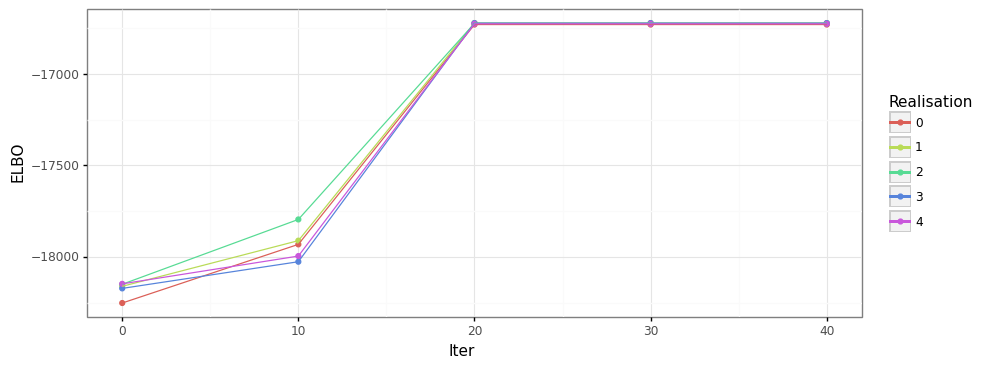

<ggplot: (8746453494522)>

In [23]:
diag_obj.plot_elbo_values()

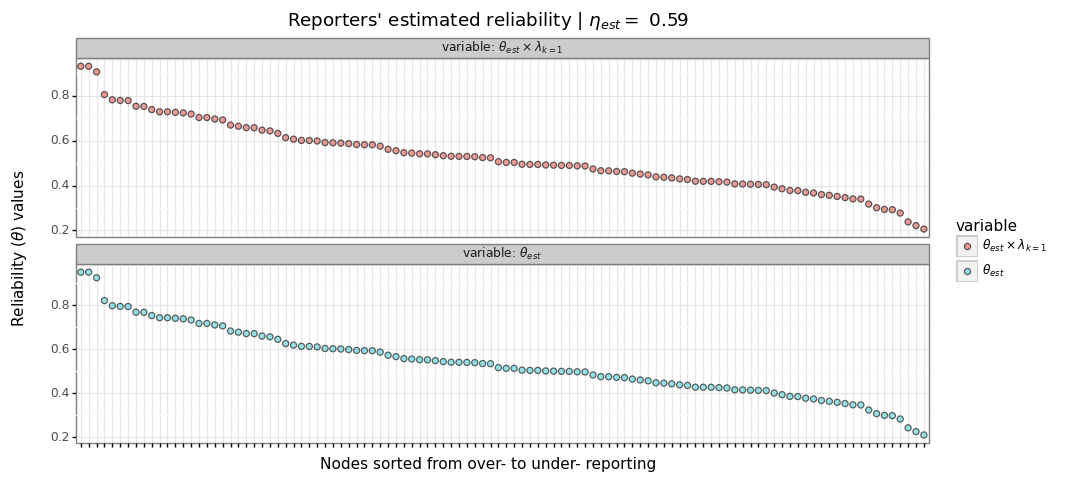

<ggplot: (8746453441274)>

In [24]:
g = diag_obj.plot_theta(return_node_order=False)

# ggsave(g, filename="/mnt/data/output/real_data/nicaragua/nicaragua_reliability_distribution.png")

g

In [25]:
print(f"Reciprocity X (union)         = {X_union_reciprocity:.3f}")
print(f"Reciprocity X (intersection)  = {X_intersection_reciprocity:.3f}")

print()

print(r"Reciprocity ViMuRe(T)         = %.3f (threshold on rho = %.3f)" % 
      (custom_reciprocity_scoring_fixed_threshold(model), vm.utils.get_optimal_threshold(model)))

Reciprocity X (union)         = 0.762
Reciprocity X (intersection)  = 0.713

Reciprocity ViMuRe(T)         = 0.199 (threshold on rho = 0.308)


# Re-run

Since the model was able to learn who the exaggerator was (in line with ethnographic insight), one can run the model twice: the first time is just to learn the $\theta_m$ starting from a weak and uniform prior. Then, one can run the model once more, setting the prior of $\theta_m$ around what was learned in the previous step. 

Priors won't be uniform this time, but the magnitude will reflect what the model expects to be exaggerators or under-reporters, it is proportional to $\theta_m$ inferred at the first step. <sup> [(related concept)](https://www.wikiwand.com/en/Recursive_Bayesian_estimation)</sup>

## New priors

In [26]:
# Use previous theta posterior to calculate new prior for alpha_theta 
theta_prior_GT = np.copy(model.G_exp_theta_f[0])

beta_theta = 10
alpha_theta = 7 * theta_prior_GT * beta_theta

gamma_shp_prior = alpha_theta * np.ones((model.L,model.M)) 
gamma_rte_prior = beta_theta * np.ones((model.L,model.M)) 

# Set theta_prior differently for nodes that do not report any tie
null_value = np.exp(sp.psi(10) - np.log(10))
special_prior = np.where(theta_prior_GT == null_value)[0] # nodes that do not report any tie

theta_prior = (gamma_shp_prior,gamma_rte_prior)
theta_prior[1][0,special_prior] = 10
theta_prior[0][0,special_prior] = null_value

rho_prior = None

## Model

In [27]:
model2 = vm.model.VimureModel(mutuality=True, undirected=False, verbose=False)

model2.fit(X=network.X,
           R=network.R,
           K=2,
           num_realisations=NUM_REALISATIONS,
           max_iter=MAX_ITER,
           theta_prior = theta_prior,
           lambda_prior = (alpha_lambda,beta_lambda),
           seed=SEED,
           bias0 = 0,
           rho_prior = rho_prior)

VimureModel(verbose=False)

## Diagnostics

In [28]:
diag_obj2 = vm.diagnostics.Diagnostics(model2, network)
diag_obj2

---------------
- DIAGNOSTICS -
---------------

Model: ViMuRe(T)

  Priors:
   - eta:    shp=0.50 rte=1.00
   - theta:  shp=36.34 rte=10.00
   - lambda: shp=[[ 1000. 10000.]] rte=[[10000. 10000.]]
   - rho:    a (1, 108, 108, 2) tensor (to inspect it, run <diag_obj>.model.pr_rho)

  Posteriors:
   - G_exp_lambda_f: [[0.04762393 0.82271966]]
   - G_exp_nu_f: 0.54
   - G_exp_theta_f: a (1, 108) tensor (to inspect it, run <diag_obj>.model.G_exp_theta_f)

Optimisation:

   Elbo: -15407.490869378056

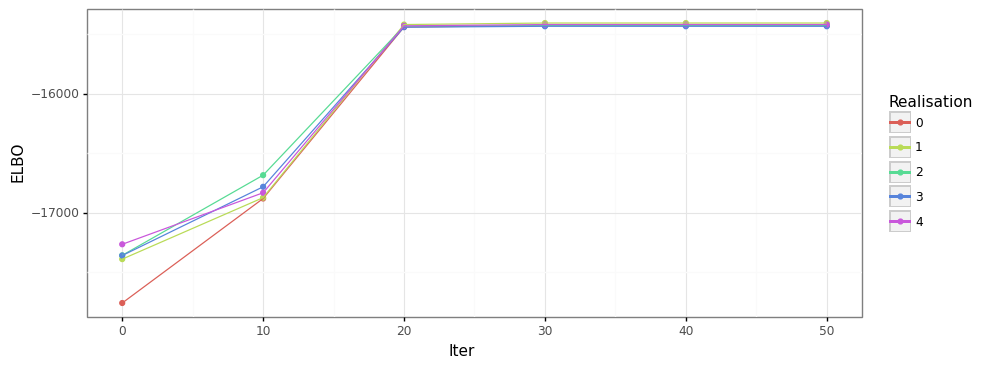

<ggplot: (8746453498109)>

In [29]:
diag_obj2.plot_elbo_values()

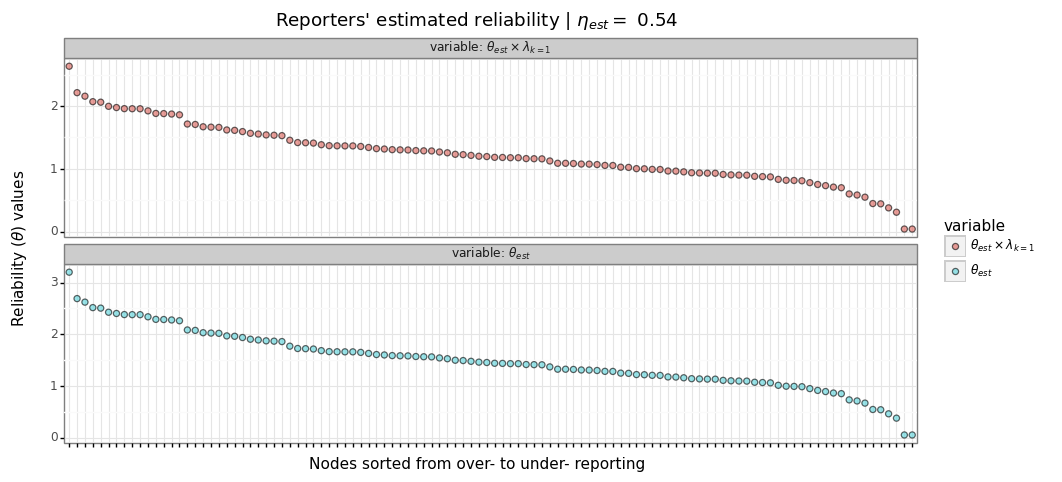

<ggplot: (8746453079549)>

In [30]:
g = diag_obj2.plot_theta(return_node_order=False)

# ggsave(g, filename="/mnt/data/output/real_data/nicaragua/nicaragua_reliability_distribution.png")

g

In [31]:
print(f"Reciprocity X (union)         = {X_union_reciprocity:.3f}")
print(f"Reciprocity X (intersection)  = {X_intersection_reciprocity:.3f}")

print()

print(r"Reciprocity ViMuRe(T)         = %.3f (threshold on rho = %.3f)" % 
      (custom_reciprocity_scoring_fixed_threshold(model2), vm.utils.get_optimal_threshold(model2)))


Reciprocity X (union)         = 0.762
Reciprocity X (intersection)  = 0.713

Reciprocity ViMuRe(T)         = 0.108 (threshold on rho = 0.283)


In [49]:
reliabilities_df = pd.DataFrame(
                        {
                            "num_realisations": model2.num_realisations,
                            "max_iter": model2.max_iter,
                            "initial_seed": SEED,
                            "best_seed": model2.seed,
                            "best_elbo": model2.maxL,
                            "model": "ViMuRe_T",
                            "village": "Nicaragua",
                            "variable": r"$\theta_{est}$",
                            "node": range(model2.M),
                            "is_node_reporter": [node in reporters for node in range(model2.M)],
                            "value": model2.G_exp_theta_f[0] * model2.G_exp_lambda_f[0][1],
                        }
                    )

# Export files for further insepction

In [33]:
Y_posterior = model2.rho_f[0,:,:,1]

l,i,j,m = network.X.subs

g = nx.from_numpy_matrix(Y_posterior, create_using=nx.DiGraph) 
nx.set_node_attributes(g, {i: val for i, val in enumerate(model2.G_exp_theta_f[0] * model2.G_exp_lambda_f[0][1])}, 
                           "reliability")

pandas_df = nx.to_pandas_edgelist(g)
pandas_df.columns = ["source", "target", "vimure_posterior_probability"]

# Reassign numbers so that it matches Jeremy's numbering
pandas_df["source"] = pandas_df["source"] + 1
pandas_df["target"] = pandas_df["target"] + 1

pandas_df["dyad_ID"] = pandas_df.apply(lambda x: f"{int(x['source'])}_{int(x['target'])}", axis=1)
pandas_df["source_reliability"] = pandas_df["source"].apply(lambda x: g.nodes()[x-1]['reliability'])
pandas_df["target_reliability"] = pandas_df["target"].apply(lambda x: g.nodes()[x-1]['reliability'])

pandas_df["source_report"] = pandas_df.apply(lambda x: np.any((i == (x['source'] - 1)) & (m == (x['source'] - 1)) & (j == (x['target'] - 1))), axis=1)
pandas_df["target_report"] = pandas_df.apply(lambda x: np.any((i == (x['source'] - 1)) & (m == (x['target'] - 1)) & (j == (x['target'] - 1))), axis=1)


In [33]:
# pandas_df.to_csv("/mnt/data/output/real_data/nicaragua/nicaragua_Y_probabilities.csv", index=False)

The main exagerator id=77

In [34]:
i = 77
pandas_df[pandas_df['target']==i].sort_values(by=['target_reliability','vimure_posterior_probability'],ascending=False).head(n=60)

,source,target,vimure_posterior_probability,dyad_ID,source_reliability,target_reliability,source_report,target_report
508,5,77,9.575901e-01,5_77,0.310110,2.633163,True,True
7636,71,77,7.979983e-01,71_77,1.872701,2.633163,True,True
11200,104,77,7.568715e-01,104_77,1.957195,2.633163,True,True
9256,86,77,7.225552e-01,86_77,0.990196,2.633163,True,True
1264,12,77,6.244848e-01,12_77,1.183437,2.633163,True,True
292,3,77,6.082309e-01,3_77,0.938204,2.633163,True,True
2452,23,77,5.861155e-01,23_77,0.443836,2.633163,False,True
9148,85,77,5.386314e-01,85_77,0.042444,2.633163,False,True
3856,36,77,5.040423e-01,36_77,0.751693,2.633163,False,True
11632,108,77,4.850539e-01,108_77,0.601119,2.633163,False,True


# Plot: Reliability distribution

/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 3 in image.
/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /mnt/data/output/real_data/nicaragua/vimure_nicaragua_distribution_reliability.pdf
/opt/conda/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/opt/conda/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


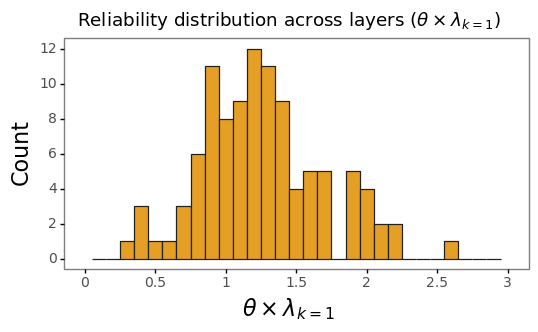

<ggplot: (8746403834908)>

In [66]:
plot_df = reliabilities_df[reliabilities_df["is_node_reporter"]].copy()

g = (ggplot(plot_df,  aes(x="value", fill="variable")) +
     geom_histogram(binwidth=0.1, color="#212121") +
     theme_bw() + 
     scale_fill_manual(values=COLORS, guide=False) +
     theme(figure_size=(6, 3),
           axis_text_x=element_text(size=10),
           axis_text_y=element_text(size=10),
           panel_grid_minor=element_blank(),
           panel_grid_major=element_blank(),           
           strip_background = element_blank(),
           strip_text_x = element_text(size=10),
           axis_title=element_text(size=16)) +
     scale_x_continuous(name=r"$\theta \times \lambda_{k=1}$", breaks=np.arange(0, 3.5, 0.5), limits=(0, 3)) +
     scale_y_continuous(name="Count", breaks=np.arange(0, 12+2, 2), limits=(0, 12)) +
     ggtitle(r"Reliability distribution across layers ($\theta \times \lambda_{k=1}$)"))

ggsave(g + ggtitle(""), "/mnt/data/output/real_data/nicaragua/vimure_nicaragua_distribution_reliability.pdf")

g

# Calculate Network Statistics

**Get graphs**

In [35]:
def build_networkx_graph(matrix):
    g = nx.from_numpy_matrix(matrix, create_using=nx.DiGraph)

    nx.set_node_attributes(g, {i: val for i, val in enumerate(g.nodes())}, "name")
    nx.set_node_attributes(g, {i: val for i, val in enumerate(model.G_exp_theta_f[0] * model.G_exp_lambda_f[0][1])}, "reliability")
    nx.set_node_attributes(g, {i: "gray" for i in g.nodes}, "nodecolor")
    
    return g


G_union = build_networkx_graph(X_union[0])
G_intersection = build_networkx_graph(X_intersection[0])
G_vimure = build_networkx_graph(vm.utils.apply_rho_threshold(model2)[0])

graphs = {
    "union": G_union,
    "intersection": G_intersection,
    "vimure": G_vimure,
    "incoming_layer": G_ego_gets_report,
    "outgoing_layer": G_ego_gives_report
}

**Calculate network statistics**

In [36]:
def calculate_net_stats(name, G):
    
    # Avg number of nominations (outgoing edges) per reporter
    out_degrees = [d for _, d in G.out_degree()]
    avg_out_degree = np.mean(out_degrees)
    std_out_degree = np.std(out_degrees)
    
    
    return pd.DataFrame({"num_edges":       G.number_of_edges(),
                         "avg_out_degree":  f"$ {avg_out_degree:.2f} \pm {std_out_degree:.2f}$",
                         "transitivity" :   f"{nx.transitivity(G):.2f}",
                         "reciprocity"  :   f"{nx.overall_reciprocity(G):.2f}"
                        },
                        index=[name])

net_stats_df = pd.concat([calculate_net_stats(name, g) for name, g in graphs.items()])
net_stats_df

,num_edges,avg_out_degree,transitivity,reciprocity
union,4131,$ 38.25 \pm 16.82$,0.52,0.76
intersection,1422,$ 13.17 \pm 7.69$,0.38,0.71
vimure,1517,$ 14.05 \pm 7.18$,0.16,0.11
incoming_layer,2595,$ 24.03 \pm 12.12$,0.40,0.46
outgoing_layer,2958,$ 27.39 \pm 16.34$,0.40,0.55


In [37]:
print(net_stats_df.to_latex().replace("\\textbackslash pm", "\\pm").replace("\\$", "$"))

\begin{tabular}{lrlll}
\toprule
{} &  num\_edges &      avg\_out\_degree & transitivity & reciprocity \\
\midrule
union          &       4131 &  $ 38.25 \pm 16.82$ &         0.52 &        0.76 \\
intersection   &       1422 &   $ 13.17 \pm 7.69$ &         0.38 &        0.71 \\
vimure         &       1517 &   $ 14.05 \pm 7.18$ &         0.16 &        0.11 \\
incoming\_layer &       2595 &  $ 24.03 \pm 12.12$ &         0.40 &        0.46 \\
outgoing\_layer &       2958 &  $ 27.39 \pm 16.34$ &         0.40 &        0.55 \\
\bottomrule
\end{tabular}



## Ego Networks

Black lines indicate **reciprocated** ties, lighter lines indicates nodes that are not reciprocated.

In [38]:
def filter_edge_constructor(selected_ego):
    def filter_edge(n1, n2):
        return n1 == selected_ego or n2 == selected_ego and n1 != n2
    return filter_edge

def plot_ego_net(node_id, 
                 G_union=G_union,
                 G_intersection=G_intersection,
                 G_vimure=G_vimure,
                 ego_color=COLORS[0], 
                 node_color=COLORS[1],
                 ego_size=200,
                 node_size=100,
                 layout="spring",
                 font_size=4):
    
    fig = plt.figure(1, figsize=(10, 4), dpi=200)
    plt.figure(1)
    
    # Obtain all relevant nodes first
    neighbours = \
        set([node_id])\
        .union(set(G_union.predecessors(node_id))).union(set(G_union.successors(node_id)))\
        .union(set(G_intersection.predecessors(node_id))).union(set(G_intersection.successors(node_id)))\
        .union(set(G_vimure.predecessors(node_id))).union(set(G_vimure.successors(node_id)))
    
    
    g = nx.subgraph_view(G_union, 
                         filter_node=lambda n: n in neighbours, 
                         filter_edge=filter_edge_constructor(node_id))
    
    pos = layout(g)
    
    def draw_individual_network(hub_ego, pos, ax):

        node_sizes = [ego_size if i == node_id else node_size for i in pos.keys()]
        node_colors = [ego_color if i == node_id else node_color for i in pos.keys()]
        
        # If reciprocated: #21212144, else #98989833
        edge_colors = ["#21212144" if (edge[1], edge[0]) in hub_ego.edges else "#98989833" for edge in hub_ego.edges]
        
        
        nx.draw_networkx(hub_ego, pos, 
                         nodelist = list(pos.keys()),
                         node_color=node_colors, 
                         node_size=node_sizes, 
                         alpha=0.65,
                         ax=ax,
                         font_color="#202020dd", font_size=font_size,
                         arrowsize=3.5,
#                          connectionstyle='arc3, rad = 0.85',
                         edge_color=edge_colors, node_shape='o')
        
        plt.axis("off")
        plt.xlim([-1.2, 1.2])
        plt.ylim([-1.2, 1.2])

    
    ax = plt.subplot(131)
    draw_individual_network(g, pos=pos, ax=ax)
    title = 'Node %s \n Ego Network: Union \n' % node_id
    ax.set_title(title)

    g = nx.subgraph_view(G_intersection, 
                         filter_node=lambda n: n in neighbours, 
                         filter_edge=filter_edge_constructor(node_id))

    ax = plt.subplot(132)
    draw_individual_network(g, pos=pos, ax=ax)
    
    title = 'Node %s \n Ego Network: Intersection \n' % node_id
    ax.set_title(title)
        
    g = nx.subgraph_view(G_vimure, 
                         filter_node=lambda n: n in neighbours, 
                         filter_edge=filter_edge_constructor(node_id))
    
    ax = plt.subplot(133)
    draw_individual_network(g, pos=pos, ax=ax)    
    title = 'Node %s \n Ego Network: Vimure\n' % node_id
    title += r'$G[\hat{\theta}]$ = ' 
    title += '%.2f' % (reliabilities_df[reliabilities_df["node"] == node_id]["value"].values[0])
    ax.set_title(title)
    

**Plot node_id=4**

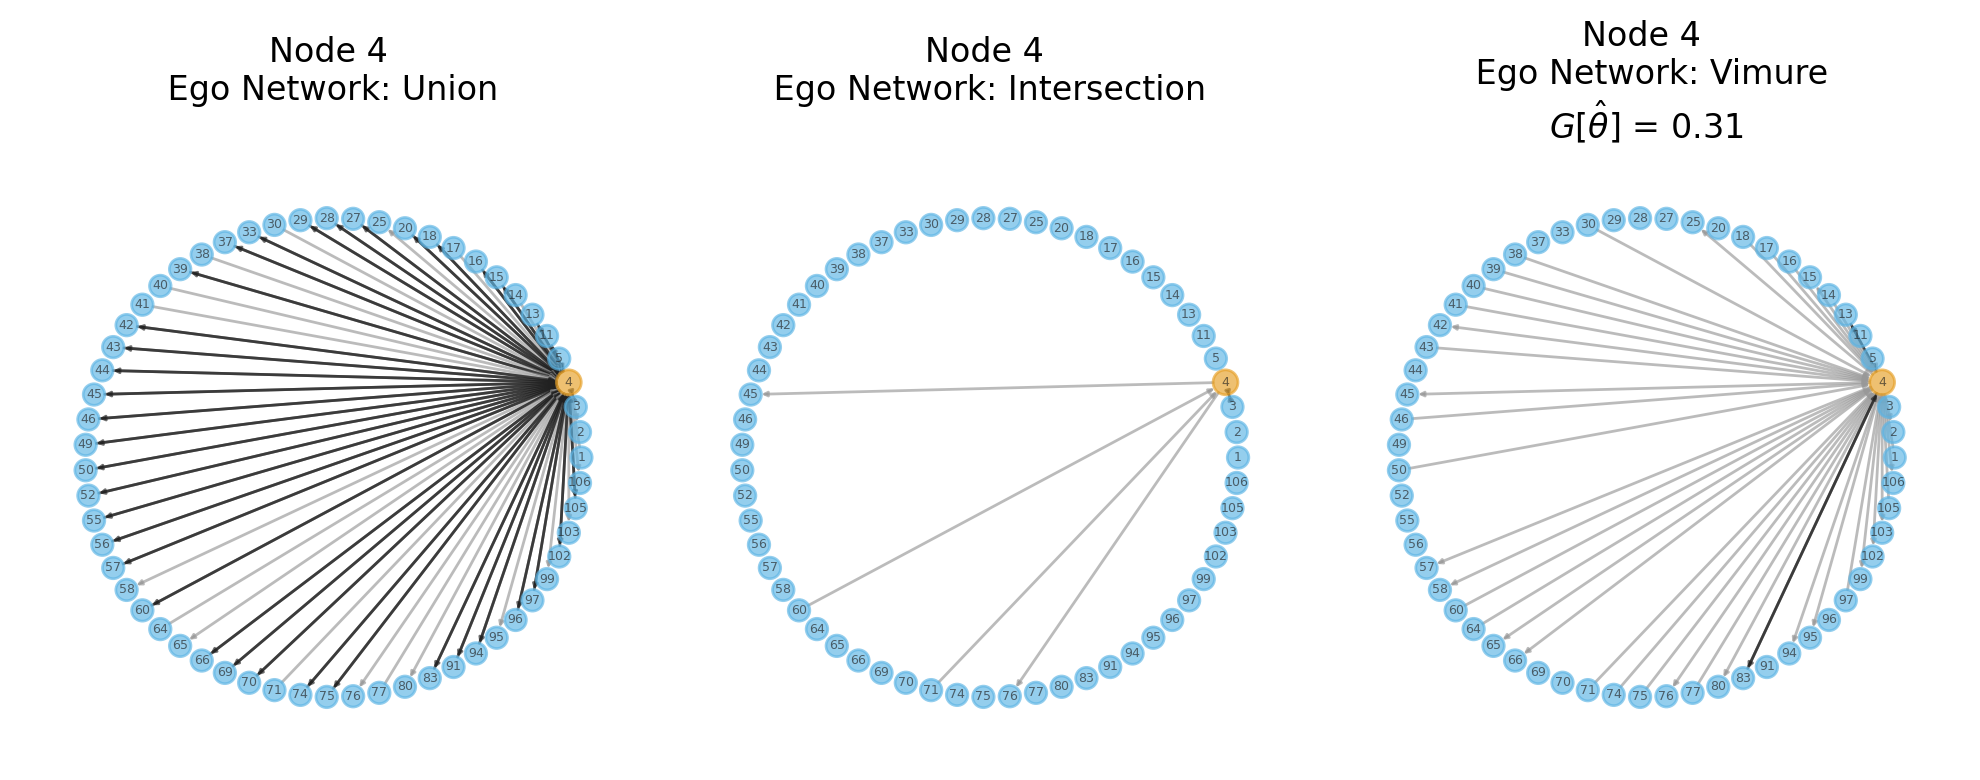

In [37]:
plot_ego_net(node_id=4, font_size=4.5, ego_size=80, node_size=60, layout=lambda G: nx.circular_layout(G, scale=0.95))
plt.tight_layout()
# plt.savefig("/mnt/data/output/real_data/nicaragua/nicaragua_example_reports_node4.pdf")

**Plot node_id=5**

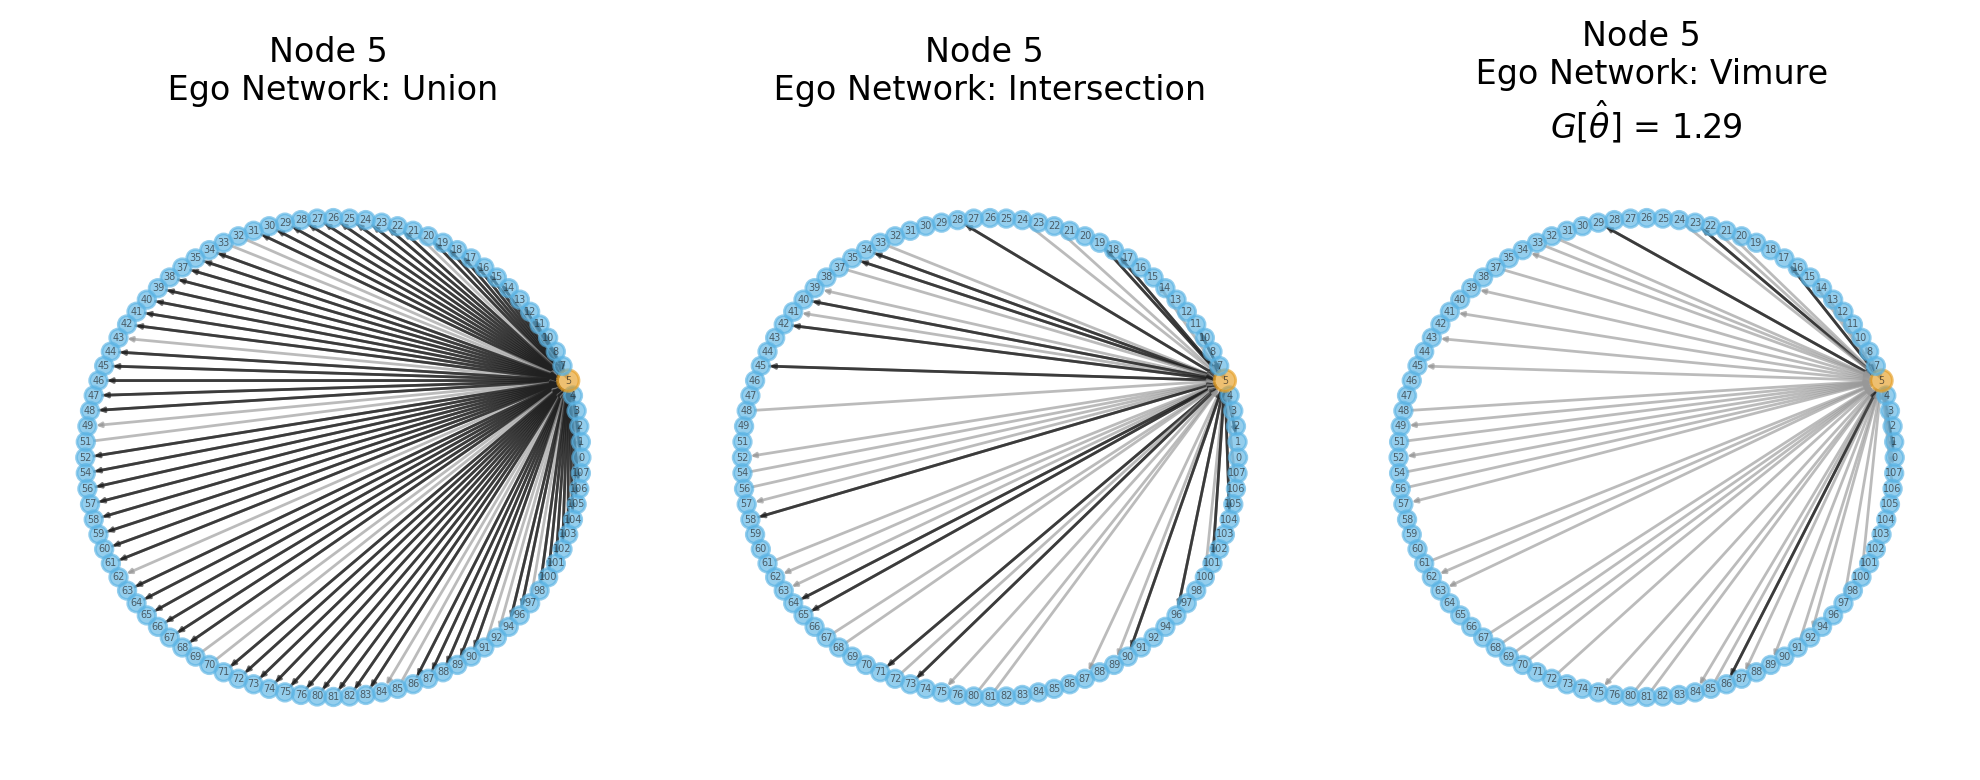

In [38]:
plot_ego_net(node_id=5, font_size=3.5, ego_size=60, node_size=40, layout=lambda G: nx.circular_layout(G, scale=0.95))
plt.tight_layout()
# plt.savefig("/mnt/data/output/real_data/nicaragua/nicaragua_example_reports_node5.pdf")

**Plot node_id=3**

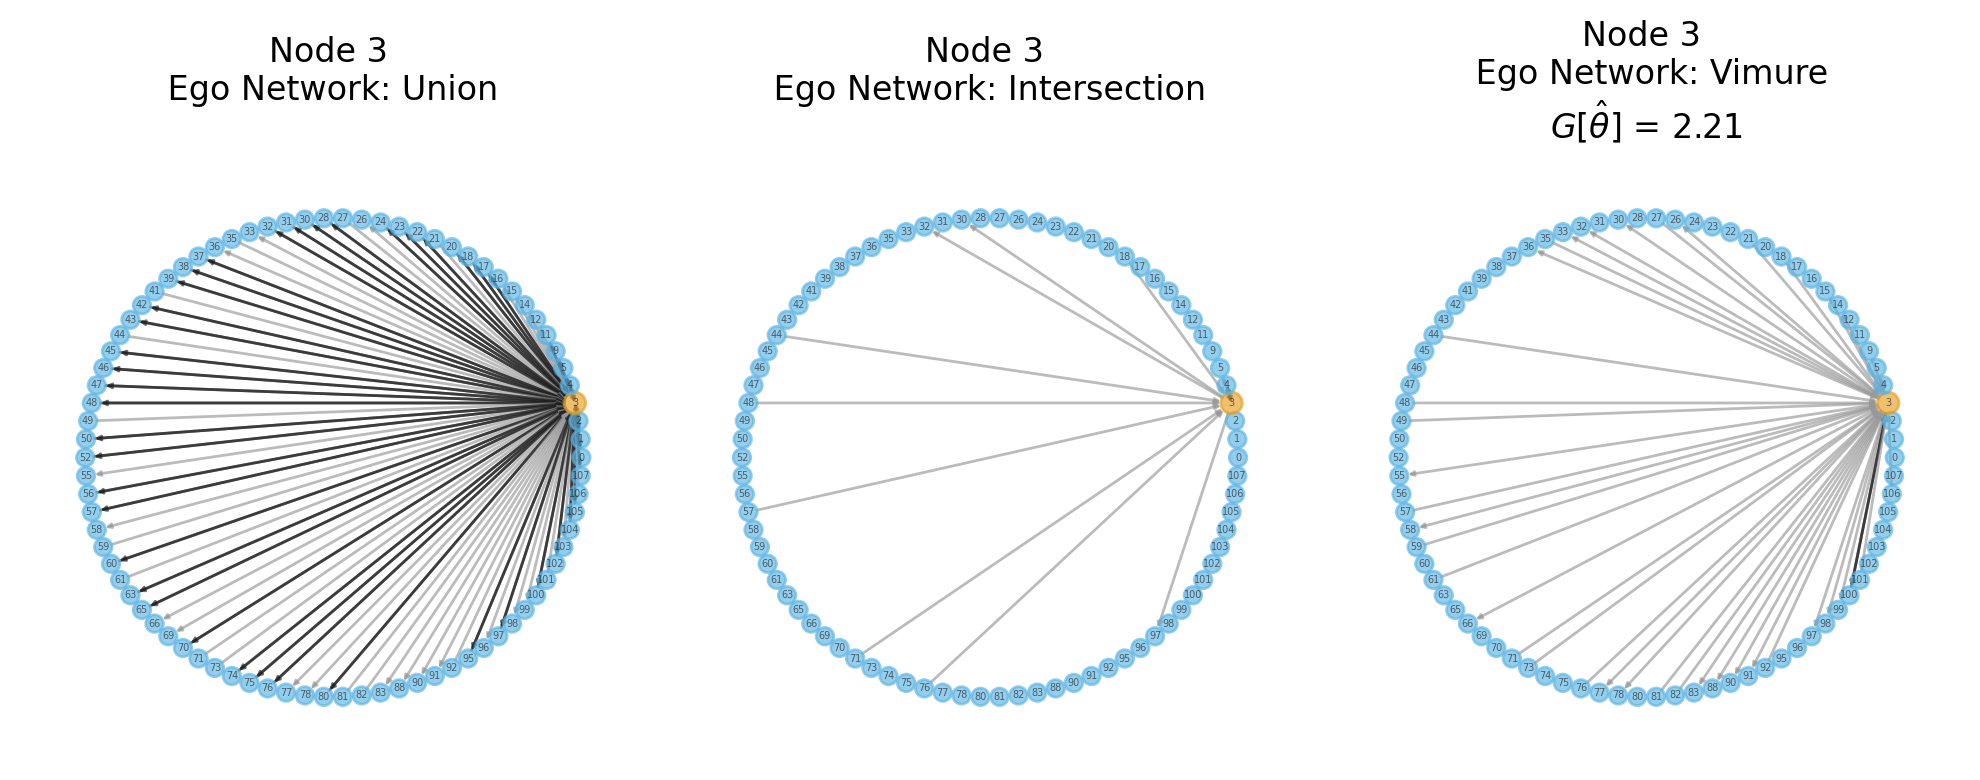

In [39]:
plot_ego_net(node_id=3, font_size=3.5, ego_size=60, node_size=40, layout=lambda G: nx.circular_layout(G, scale=0.95))
plt.tight_layout()
# plt.savefig("/mnt/data/output/real_data/nicaragua/nicaragua_example_reports_node3.pdf")

**Plot node_id=76**

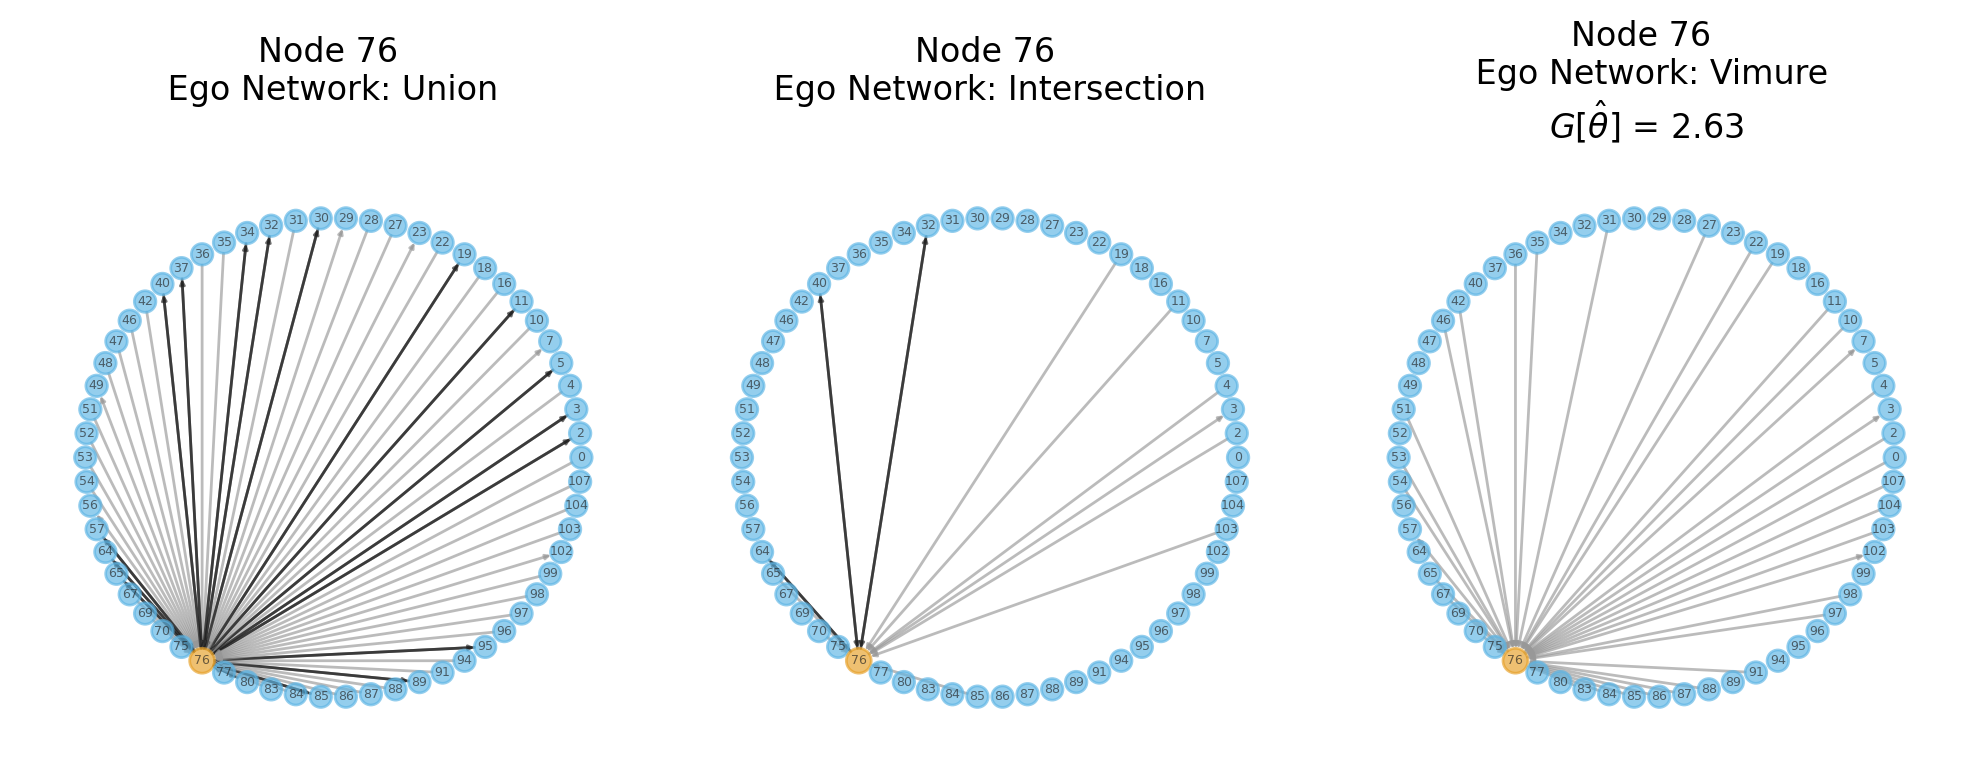

In [40]:
plot_ego_net(node_id=76, font_size=4.5, ego_size=80, node_size=60, layout=lambda G: nx.circular_layout(G, scale=0.95))
plt.tight_layout()
# plt.savefig("/mnt/data/output/real_data/nicaragua/nicaragua_example_reports_node76.pdf")

# Who is the exagerator

In [41]:
reliabilities_df.sort_values(by=["value"], ascending=False)

,num_realisations,max_iter,initial_seed,best_seed,best_elbo,model,village,variable,node,value
76,5,101,1,1216,-15407.490869,ViMuRe_T,Nicaragua,$\theta_{est}$,76,2.633163
3,5,101,1,1216,-15407.490869,ViMuRe_T,Nicaragua,$\theta_{est}$,3,2.212759
16,5,101,1,1216,-15407.490869,ViMuRe_T,Nicaragua,$\theta_{est}$,16,2.156503
69,5,101,1,1216,-15407.490869,ViMuRe_T,Nicaragua,$\theta_{est}$,69,2.069323
12,5,101,1,1216,-15407.490869,ViMuRe_T,Nicaragua,$\theta_{est}$,12,2.061100
...,...,...,...,...,...,...,...,...,...,...
22,5,101,1,1216,-15407.490869,ViMuRe_T,Nicaragua,$\theta_{est}$,22,0.443836
31,5,101,1,1216,-15407.490869,ViMuRe_T,Nicaragua,$\theta_{est}$,31,0.379341
4,5,101,1,1216,-15407.490869,ViMuRe_T,Nicaragua,$\theta_{est}$,4,0.310110
93,5,101,1,1216,-15407.490869,ViMuRe_T,Nicaragua,$\theta_{est}$,93,0.042444


In [42]:
reliabilities_df[((reliabilities_df["node"] == 76))]\
.set_index(["variable", "village", "initial_seed", "best_seed"])[["node", "value"]]

,,,,node,value
variable,village,initial_seed,best_seed,,
$\theta_{est}$,Nicaragua,1,1216,76,2.633163


# Inspect reported ties


In [39]:
labels = ["conf_give_to", "conf_get_from", "not_conf_give_to_alter", "not_conf_get_from_alter", "not_conf_give_to_ego", "not_conf_get_from_ego"]
colors = ['forestgreen', 'lightgreen', 'indianred', 'lightsalmon', 'dodgerblue', 'skyblue']

def reliability_interactions(rep_id, 
                             reliabilities_df=reliabilities_df, 
                             network=network,
                             verbose=False, 
                             undirected=False):
    
    l, i, j, m = network.X.subs
    ties_reported_by_rep_id = np.argwhere(m == rep_id).flatten()
    
    rep_in_deg  = np.argwhere(j[ties_reported_by_rep_id] == rep_id).size
    rep_out_deg = np.argwhere(i[ties_reported_by_rep_id] == rep_id).size
    
    rep_theta = reliabilities_df[(reliabilities_df["node"]    == rep_id)]["value"].values[0]
    
    if verbose:
        print(f'Reporter id {rep_id}')
        print(f'\ntheta(rep_id): {rep_theta}')
        if undirected:
            print(f'Reported Degree: {rep_in_deg}')
        else:
            print(f'Reported In-degree: {rep_in_deg} -- Reported Out-degree: {rep_out_deg}')

    #######################################################
    # EGO : Incoming and outgoing ties reported by rep_id #
    #######################################################
    id_incoming_ties = ties_reported_by_rep_id[np.argwhere(j[ties_reported_by_rep_id] == rep_id)].flatten()
    id_outgoing_ties = ties_reported_by_rep_id[np.argwhere(i[ties_reported_by_rep_id] == rep_id)].flatten()
    
    ego_get_from_ = set(i[id_incoming_ties]) 
    if not undirected:
        ego_give_to_ = set(j[id_outgoing_ties])
        if len(ego_get_from_.union(ego_give_to_)) > 0:
            ind_rec = len(ego_get_from_.intersection(ego_give_to_)) / len(ego_get_from_.union(ego_give_to_))
        else:
            ind_rec = 0.
    if verbose:
        if not undirected:
            print(f'Individual reciprocity: {ind_rec:.2}')
        print(f'\nNominated subjects:')
        if undirected:
            print(f'\tego: {len(ego_get_from_)}')
        else:
            print(f'\tego_give_to : {len(ego_give_to_)} \n\tego_get_from: {len(ego_get_from_)}')

    ################################################################################
    # ALTERS : Incoming and outgoing ties of rep_id as reported by other reporters #
    ################################################################################
    
    ties_NOT_reported_by_rep_id = (m != rep_id)
    
    id_incoming_ties = np.argwhere(np.logical_and(j == rep_id, ties_NOT_reported_by_rep_id)).flatten()
    id_outgoing_ties = np.argwhere(np.logical_and(i == rep_id, ties_NOT_reported_by_rep_id)).flatten()
    
    alter_give_to_ = set(j[id_outgoing_ties])
    if not undirected:
        alter_get_from_ = set(i[id_incoming_ties])

    conf_get_from = len(ego_get_from_.intersection(alter_give_to_))
    not_conf_get_from_alter = len(ego_get_from_.difference(alter_give_to_))
    not_conf_get_from_ego = len(alter_give_to_.difference(ego_get_from_))
    if not undirected:
        conf_give_to = len(ego_give_to_.intersection(alter_get_from_))
        not_conf_give_to_alter = len(ego_give_to_.difference(alter_get_from_))
        not_conf_give_to_ego = len(alter_get_from_.difference(ego_give_to_))

    if verbose:
        print(f'\nGet nominated:')
        # print(f'Number of people who claim to get help from: {len(alter_get_from_)}')
        # print(f'Number of people who claim to give help to: {len(alter_give_to_)}')
        if undirected:
            print(f'\tConfirmed relationships: {conf_get_from}')
            print(f'\tNot confirmed (by alter): {not_conf_get_from_alter}')
            print(f'\tNot nominated (by ego): {not_conf_get_from_ego}')
        else:
            print(f'\tConfirmed relationships for give_to: {conf_give_to}')
            print(f'\tConfirmed relationships for get_from: {conf_get_from}')
            print(f'\tNot confirmed ego_give_to (by alter): {not_conf_give_to_alter}')
            print(f'\tNot confirmed ego_get_from (by alter): {not_conf_get_from_alter}')
            print(f'\tNot nominated ego_give_to (by ego): {not_conf_give_to_ego}')
            print(f'\tNot nominated ego_get_from (by ego): {not_conf_get_from_ego}')

    if undirected:
        toreturn = {'rep_id': rep_id,
                    'rep_theta': rep_theta,
                    'conf_get_from': conf_get_from, 
                    'not_conf_get_from_alter': not_conf_get_from_alter, 
                    'not_conf_get_from_ego': not_conf_get_from_ego}
    else:
        toreturn = {'rep_id': rep_id,
                    'rep_theta': rep_theta,
                    'conf_give_to': conf_give_to, 
                    'conf_get_from': conf_get_from, 
                    'not_conf_give_to_alter': not_conf_give_to_alter, 
                    'not_conf_get_from_alter': not_conf_get_from_alter, 
                    'not_conf_give_to_ego': not_conf_give_to_ego, 
                    'not_conf_get_from_ego': not_conf_get_from_ego}

    return toreturn

## Radial plot

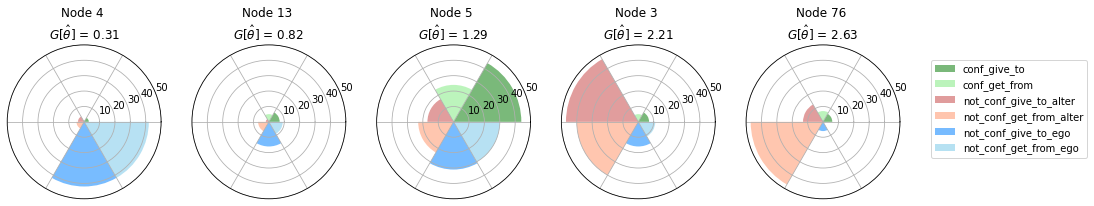

In [42]:
selected_reporters = [4, 13, 5,  3, 76]


plt.figure(figsize=(16,4))
maxval = 60
l = 0

pie_values = np.linspace(0.0, 2 * np.pi, 6, endpoint=False)
width = (2*np.pi) / 6

for subplot_id, rep_id in enumerate(selected_reporters):
    values_rec = reliability_interactions(rep_id)
    rep_theta = values_rec["rep_theta"]

    values_rec = list(values_rec.values())[2:]

    ax = plt.subplot(151 + subplot_id, polar=True)
    bars = ax.bar(pie_values, values_rec, width=width, bottom=0, align='edge')
    ax.xaxis.set_ticks(pie_values)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticks(np.arange(0, maxval, 10)[1:])
    title = 'Node %s \n' % rep_id
    title += r'$G[\hat{\theta}]$ = ' 
    title += '%.2f' % (rep_theta)
    ax.set_title(title)
    for r, bar in enumerate(bars):
        bar.set_facecolor(colors[r])
        bar.set_alpha(0.6)
        bar.set_label(labels[r])

plt.legend(loc=[1.2, 0.265])
# plt.margins(0.015, tight=True)
plt.savefig("/mnt/data/output/real_data/nicaragua/nicaragua_example_reports.pdf", dpi=300, bbox_inches = "tight")

plt.show()

## Bar plots

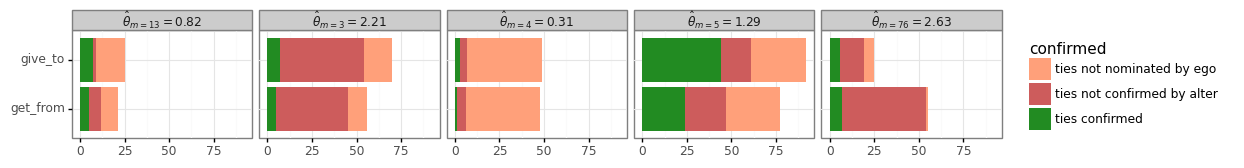

<ggplot: (8782639181207)>

In [45]:
plot_df = pd.concat([pd.DataFrame(reliability_interactions(rep_id, verbose=False), index=[0])
                     for rep_id in selected_reporters])

plot_df = pd.melt(plot_df, id_vars=["rep_id", "rep_theta"])
plot_df["label"] = plot_df.apply(lambda x: r"$\hat{\theta}_{m=%s} = %.2f$" % (x["rep_id"], x["rep_theta"]), axis=1)
plot_df['tie_direction'] = plot_df['variable'].apply(lambda x: 'give_to' if 'give_to' in x else 'get_from')



def get_confirmed_label(x):
    if 'not_conf_' in x['variable']:
        if 'alter' in x['variable']:
            return 'ties not confirmed by alter'
        else:
            return 'ties not nominated by ego'
    else:
        return 'ties confirmed'

plot_df['confirmed'] = plot_df.apply(lambda x: get_confirmed_label(x), axis=1)
plot_df['confirmed'] = pd.Categorical(plot_df['confirmed'], 
                                      ordered=True,
                                      categories=['ties not nominated by ego',  'ties not confirmed by alter', 'ties confirmed'])

g = (ggplot(plot_df, 
            aes(x="tie_direction", y="value", fill="confirmed")) +
     geom_col(position='stack') +
     scale_fill_manual(
         values={'ties confirmed': "forestgreen", 
                 'ties not confirmed by alter': "indianred",
                 'ties not nominated by ego' : "lightsalmon"}) + 
     theme_bw() +
     coord_flip() +
     theme(figure_size=(12, 1.4),
           axis_text_x=element_text(),
           axis_title_x=element_blank(),
           axis_title_y=element_blank()) +
     facet_grid("~ label"))

# ggsave(g, "/mnt/data/output/real_data/nicaragua/nicaragua_example_reports.png")

g